# Lesson 1 - Exercise - American Sign Language

Following along with lesson 1.  I'm trying to do some of it on my own before digging into Lesson 2.  I decided to try to work with an image classifier dataset for American Sign Language I found on [Kaggle](https://www.kaggle.com/grassknoted/asl-alphabet).

In [60]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Following the example from Lesson 1, I'm importing 

* [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of 
* [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). 

The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [61]:
from fastai.vision import *
from fastai.metrics import error_rate

The compute from Google Cloud that I'm using has a `NVIDIA Tesla P100` GPU which seems ok with a batch size of 64.

In [62]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

I setup the [kaggle](https://github.com/Kaggle/kaggle-api) command line and download the data separately to `/home/jupyter/data/asl-alphabet.zip`.  I used this command

```
  kaggle datasets download grassknoted/asl-alphabet
```

I need to read up on fastai functions I can used to work with the dataset.  The structure is described on [Kaggle](https://www.kaggle.com/grassknoted/asl-alphabet).

I found helpful notes in the [fastai doc about datasets](https://docs.fast.ai/datasets.html) but my first attempts to use a fastai function to expand the dataset didn't work so well.  I decided to skip that and instead just unpacked the data on the command line

```
  unzip asl-alphabet.zip 
```

In [63]:
path = Path('../../../../../data')
# relative location of expanded data to this nb
path.ls()

[PosixPath('../../../../../data/asl-alphabet.zip'),
 PosixPath('../../../../../data/models'),
 PosixPath('../../../../../data/asl_alphabet_train'),
 PosixPath('../../../../../data/asl_alphabet_test')]

In [64]:
training_path = path/"asl_alphabet_train/asl_alphabet_train"
testing_path = path/"asl_alphabet_test/asl_alphabet_test"
# Setup the classes as the names of the directories in the training set
classes = sorted(list(map(lambda p: p.name, training_path.ls())))

In [65]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, 
                                  train='asl_alphabet_train/asl_alphabet_train',
                                  valid_pct=0.2,
                                  test = 'asl_alphabet_test/asl_alphabet_test',
                                  ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)


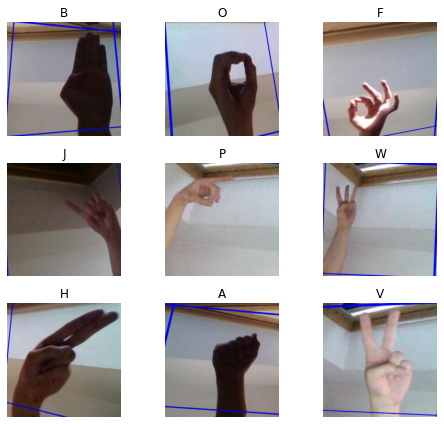

In [66]:
data.show_batch(rows=3, figsize=(7,6))

In [67]:
print(data.classes)
len(data.classes),data.c

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


(29, 29)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 29 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [68]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [69]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [70]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.184415,0.048138,0.015575,02:22
1,0.065111,0.010125,0.003161,02:22
2,0.030084,0.002906,0.000632,02:22
3,0.017133,0.001553,0.000517,02:23


In [76]:
savedModel = learn.save('stage-1-asl', True)

Apply the model to the test data and build a display

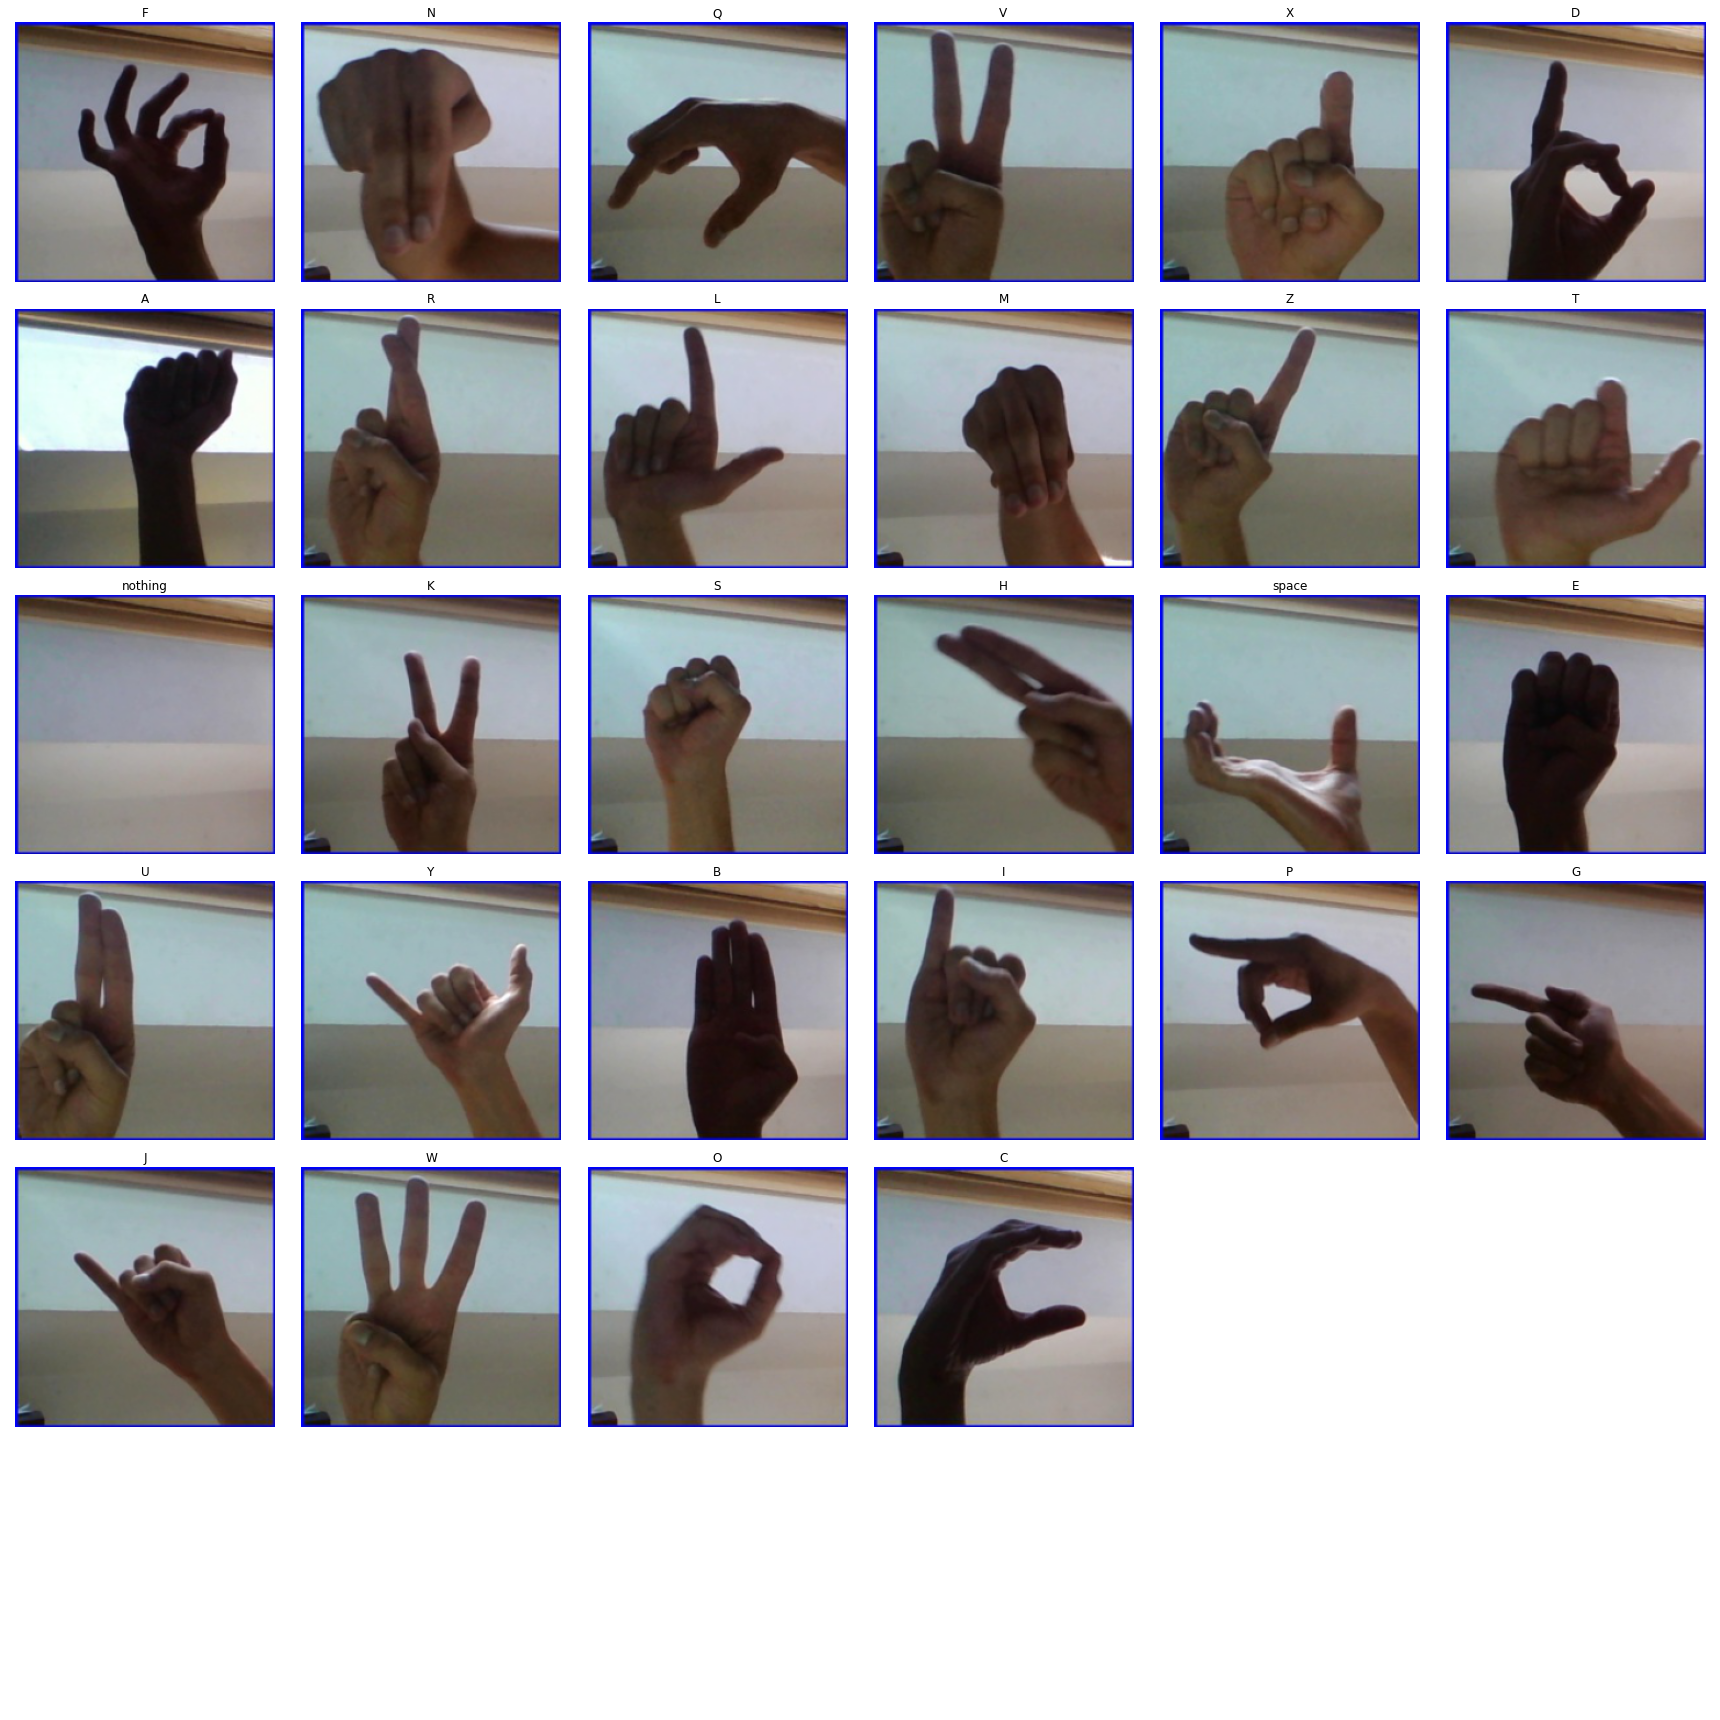

In [130]:
def readSign(i):
    return learn.predict(i[0])[0]
predictions = list(map(readSign, data.test_ds))
tdata = list(map(lambda d: d[0], data.test_ds))
data.show_xys(tdata, predictions)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

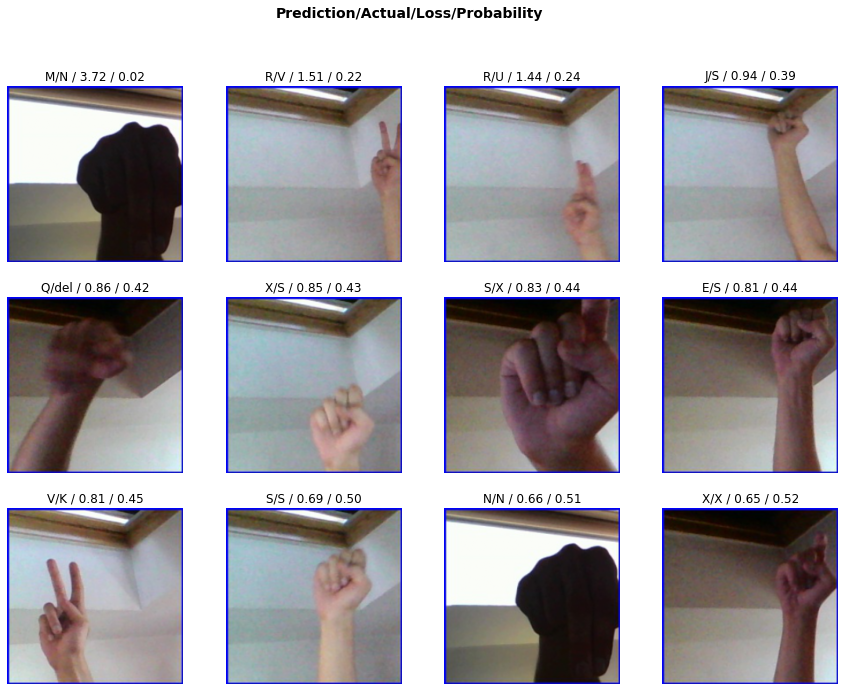

In [26]:
interp.plot_top_losses(12, figsize=(15,11))

In [28]:
doc(interp.plot_top_losses)

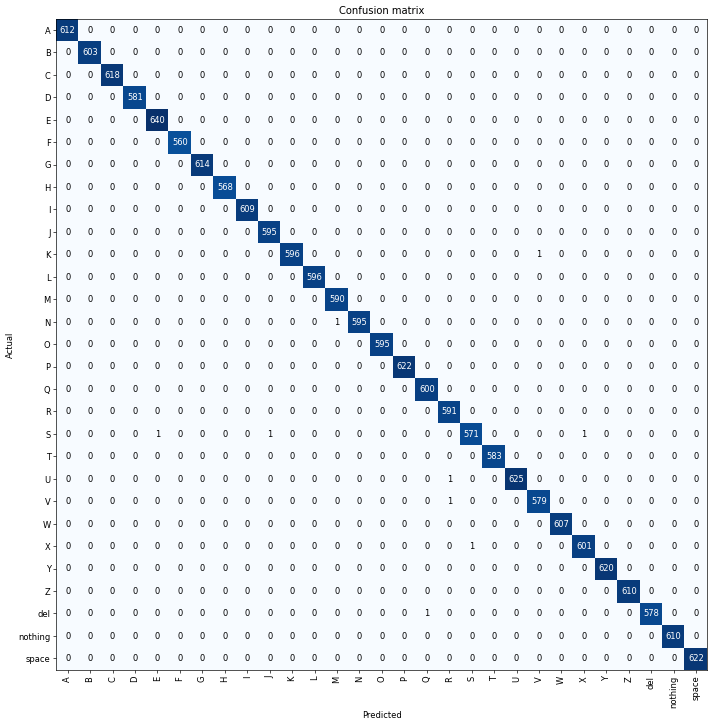

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=1)

[('K', 'V', 1),
 ('N', 'M', 1),
 ('S', 'E', 1),
 ('S', 'J', 1),
 ('S', 'X', 1),
 ('U', 'R', 1),
 ('V', 'R', 1),
 ('X', 'S', 1),
 ('del', 'Q', 1)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.011845,0.001370,0.000805,03:17


Since our error rate didn't impove of the frozen one, let's try adjusting the learing rate.

In [35]:
learn.load('stage-1'); # revert to saved model

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


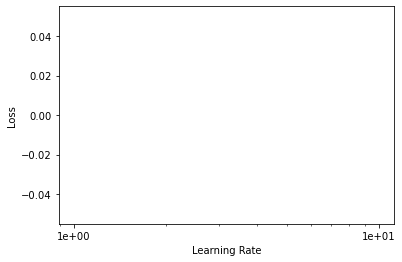

In [37]:
learn.recorder.plot()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.020336,0.001456,0.000345,03:16
1,0.008894,0.000135,0.000000,03:16


Wow!  Got to zero errors with a more focused learning rate.  There doesn't seem to be any reason to explore with this further, but I'll do the resnet50 part below just for fun.

In [40]:
learn.save('stage1-43')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [41]:
data = ImageDataBunch.from_folder(path, 
                                  train='asl_alphabet_train/asl_alphabet_train',
                                  valid_pct=0.2,
                                  test = 'asl_alphabet_test/asl_alphabet_test',
                                  ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)

In [42]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


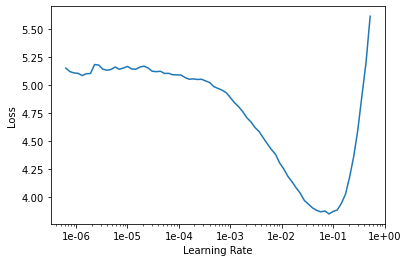

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.134730,0.055839,0.015862,09:04
1,0.063311,0.009992,0.003333,09:02
2,0.043311,0.005300,0.001264,09:02
3,0.009558,0.000504,0.000172,09:02
4,0.012218,0.000431,0.000115,09:02
5,0.002274,0.000056,0.000000,09:02
6,0.011631,0.000008,0.000000,09:02
7,0.004111,0.000012,0.000000,09:02


In [45]:
learn.save('stage-1-50')

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

In [48]:
interp.most_confused(min_val=2)

[('Q', 'P', 498),
 ('R', 'D', 392),
 ('M', 'S', 383),
 ('N', 'S', 347),
 ('U', 'D', 299),
 ('A', 'J', 290),
 ('T', 'J', 218),
 ('H', 'G', 189),
 ('U', 'X', 189),
 ('V', 'K', 163),
 ('V', 'X', 156),
 ('A', 'I', 154),
 ('R', 'X', 152),
 ('N', 'J', 134),
 ('C', 'J', 129),
 ('V', 'W', 114),
 ('X', 'I', 113),
 ('K', 'W', 101),
 ('B', 'D', 91),
 ('A', 'Z', 90),
 ('Y', 'J', 87),
 ('G', 'J', 84),
 ('U', 'B', 81),
 ('space', 'L', 81),
 ('Z', 'J', 80),
 ('E', 'S', 79),
 ('E', 'B', 78),
 ('S', 'J', 75),
 ('F', 'W', 73),
 ('N', 'E', 70),
 ('T', 'Z', 70),
 ('W', 'X', 69),
 ('K', 'I', 66),
 ('Y', 'Z', 64),
 ('del', 'P', 62),
 ('O', 'D', 60),
 ('E', 'J', 58),
 ('V', 'B', 53),
 ('M', 'E', 52),
 ('R', 'B', 51),
 ('E', 'I', 49),
 ('M', 'J', 49),
 ('H', 'J', 48),
 ('K', 'B', 48),
 ('F', 'space', 47),
 ('F', 'P', 45),
 ('W', 'B', 45),
 ('K', 'V', 44),
 ('S', 'X', 44),
 ('space', 'I', 44),
 ('W', 'P', 43),
 ('I', 'X', 42),
 ('C', 'Z', 41),
 ('P', 'C', 40),
 ('O', 'T', 39),
 ('V', 'I', 39),
 ('C', 'D', 36),